# A Neural-Network based Chatbot

Un **chatbot** este un program care simuleaza si proceseaza conversatii in limbaj natural, permitand oamenilor sa interactioneze prin intermediul dispozitivelor digitale ca si cand ar comunica cu o persoana reala.

Vom crea un framework pentru antrenarea unui chatbot si vom construi un model conversational pentru un "terapeut artificial".

Pasii necesari:
* vom transforma definitiile intentiilor intr-un model
* vom implementa un chatbot care poate procesa input uman si poate genera raspunsuri
* vom incarca informatii contextuale in starea chatbotului

In acest laborator, vom folosi [tflearn](http://tflearn.org/), un API pentru [Tensorflow](https://www.tensorflow.org/).




## 1. Transformarea definitiilor intentiilor intr-un model pentru Deep Learning

Un framework pentru un chatbot are nevoie de o structura in care intentiile conversationale sunt definite. O metoda eleganta de a realiza acest lucru este stocarea acestora intr-un fisier JSON.

Fiecare intentie conversationala contine:
*   un **tag** (un nume unic pentru intentie)
*   **patterns** (sabloane/exemple pentru textele pe care dorim sa le recunoastem ca avand aceasta intentie)
*   **responses** (o lista de raspunsuri posibile pe care le poate genera chatbotul pentru aceasta intentie)
*   **context_set** (seteaza informatii despre context) si **context_filter** (mentioneaza carui context i se potriveste intentia)

In [ ]:
! pip install tflearn

     |████████████████████████████████| 107 kB 10.3 MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=31a10236b9f4a345f7addc851ba54d5e582e9c7848055d81feaf7f4f08295f5c
  Stored in directory: /root/.cache/pip/wheels/5f/14/2e/1d8e28cc47a5a931a2fb82438c9e37ef9246cc6a3774520271
Successfully built tflearn


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('punkt')
from nltk.stem.lancaster import LancasterStemmer
stemmer = LancasterStemmer()

import numpy as np
import tflearn
import tensorflow as tf
import random

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# in cazul in care folosim colab, incarcam fisierul intents.json
from google.colab import files
uploaded = files.upload()

Saving intents.json to intents.json


Deschidem fisierul JSON care contine intentiile:

In [ ]:
import json
with open('intents.json') as json_data:
    intents = json.load(json_data)

Folosind fisierul incarcat pentru intentii, putem incepe sa organizam documentele, cuvintele si clasele pentru clasificarea de intentii. De asemenea, vom realiza o preprocesare a textelor care consta in:
* tokenizare
* stemming

De exemplu:

In [ ]:
doc = "We went to the mountains but we didn't have fun."
tokens = nltk.word_tokenize(doc)
print(tokens)
for token in tokens:
    print(token, '=>' , stemmer.stem(token))

['We', 'went', 'to', 'the', 'mountains', 'but', 'we', 'did', "n't", 'have', 'fun', '.']
We => we
went => went
to => to
the => the
mountains => mountain
but => but
we => we
did => did
n't => n't
have => hav
fun => fun
. => .


Pipeline-ul pentru preprocesarea textelor arata astfel:

In [ ]:
words = []
classes = []
documents = []
ignore_words = ['?',"'m", "'re", "'s", ')', ',', '.', ':']  # eventual aici putem defini o lista de STOPWORDS

# pentru fiecare fraza din sabloanele corespunzatoare unei intentii
for intent in intents['intents']:
    for pattern in intent['patterns']:
        # tokenizare
        w = nltk.word_tokenize(pattern)
        # adaugam cuvintele la o lista globala cu toate cuvintele din texte
        words.extend(w)
        # adaugam textul tokenizat la multimea de documente
        documents.append((w, intent['tag']))
        # adaugam clasa (tipul de intentie) la lista de clase existente
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

# aplicam stemming si lowercasing pentru fiecare cuvant intalnit, ignoram stopwords
words = [stemmer.stem(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))  # eliminam duplciate

classes = sorted(list(set(classes)))

print (len(documents), "documents", documents[0], documents[7])
print (len(classes), "classes", classes)
print (len(words), "unique stemmed words", words)

33 documents (['Hi'], 'greeting') (['I', "'m", 'happy', 'today'], 'greeting_good')
11 classes ['funny', 'goodbye', 'greeting', 'greeting_bad', 'greeting_good', 'joke', 'name', 'quote', 'real_therapy', 'thanks', 'therapy']
61 unique stemmed words ['a', 'am', 'any', 'ar', 'being', 'bright', 'bye', 'can', 'chatbot', 'com', 'day', 'do', 'ev', 'feel', 'fin', 'funny', 'good', 'goodby', 'hahah', 'happy', 'hello', 'help', 'hi', 'how', 'hum', 'i', 'is', 'jok', 'kind', 'know', 'lat', 'me', 'my', 'myself', 'nam', 'nee', 'not', 'of', 'ok', 'pretty', 'quot', 'real', 'sad', 'see', 'so', 'talk', 'tel', 'than', 'thank', 'that', 'therap', 'therapy', 'to', 'today', 'up', 'want', 'was', 'what', 'who', 'yo', 'you']


Construim o lista de documente (fraze), fiecare fraza este o lista de cuvinte pentru care a fost aplicat stemming, iar fiecare document are asociata o intentie.

Pentru a putea folosi retele neuronale, frazele trebuie transformate in vectori. Cel mai simplu este sa folosim reprezentarea **Bag of Words**.

In [ ]:
# construim datele de antrenare
training = []
output = []
# un vector de 0 de lungime egala cu numarul de clase (vom folosi reprezentarea one-hot a claselor)
output_empty = [0] * len(classes)

# bag of words pentru fiecare fraza
for doc in documents:
    # initializam bag of words
    bag = []
    # lista de tokeni pentru fraza curenta
    pattern_words = doc[0]
    # aplicam stemming
    pattern_words = [stemmer.stem(word.lower()) for word in pattern_words]
    # construim vectorul binar pentru bag of words
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output este '1' pentru tagul corespunzator frazei si '0' pentru celelalte (one-hot)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])

print(training[1])
print(type(training))

[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]
<class 'list'>


In `training` avem feature-urile pentru antrenarea modelului. Realizam un shuffle asupra documentelor din training si transformam datele intr-un numpy array (pentru a putea sa le folosim ca input intr-o retea).

In [ ]:
# shuffle + transformare in np.array
random.shuffle(training)
training = np.array(training)

print(training.shape)

(33, 2)


In mod normal, pentru a antrena un model, realizam o impartire a datelor (antrenare si testare). Pastram un set de fraze care nu au fost folosite la antrenare, si folosind acest set testam performanta modelului. In acest exemplu, `tflearn` realizeaza acest split in mod implicit, pastrand o parte din datele de antrenare pentru a evalua acuratetea modelului.

Pentru moment, definim doar doua liste: una continand feature-urile pentru antrenare (vectorii bag of words) si labelurile corespunzatoare.

In [ ]:
# feature-urile de antrenare
train_x = list(training[:,0])
# etichete/labels (ce dorim sa returneze modelul)
train_y = list(training[:,1])

Daca ne uitam la un vector din `train_x` observam reprezentarea 'bag of words', iar un vector din `train_y` contine encodarea one-hot a labelului corespunzator.

`train_x[0]` este prima fraza (document) din datele de antrenare, iar `train_y[0]` este eticheta corespunzatoare. 

In [ ]:
print(train_x[0])
print(train_y[0])

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Acum putem defini modelul pentru clasificare.

In [ ]:
from tensorflow.python.framework import ops
ops.reset_default_graph()  # resetam starea engine-ului TensorFlow

# definim reteaua
net = tflearn.input_data(shape=[None, len(train_x[0])])  # toti vectorii de bag-of-words au aceasta dimensiune
net = tflearn.fully_connected(net, 8) # strat feed-forward ascuns cu 8 noduri
net = tflearn.fully_connected(net, 8) # strat feed-forward ascuns cu 8 noduri
net = tflearn.fully_connected(net, len(train_y[0]), activation='softmax') # numarul de noduri output = numarul de clase
net = tflearn.regression(net)  # folosim acest strat de logistic regression pentru a extrage probabilitatile claselor

# definim modelul final
model = tflearn.DNN(net, tensorboard_dir='tflearn_logs')

# incepem antrenarea folosind coborarea pe gradient
# trecem prin model cate 8 fraze odata (batch size = 8)
model.fit(train_x, train_y, n_epoch=1000, batch_size=8, show_metric=True)
model.save('model.tflearn')

Training Step: 4999  | total loss: 0.11338 | time: 0.029s
| Adam | epoch: 1000 | loss: 0.11338 - acc: 0.9946 -- iter: 32/33
Training Step: 5000  | total loss: 0.10572 | time: 0.035s
| Adam | epoch: 1000 | loss: 0.10572 - acc: 0.9952 -- iter: 33/33
--
INFO:tensorflow:/content/model.tflearn is not in all_model_checkpoint_paths. Manually adding it.


Putem vizualiza evolutia metricilor de antrenare folosind [Tensorboard](https://www.tensorflow.org/tensorboard).

In [ ]:
%load_ext tensorboard
%tensorboard --logdir="/content/tflearn_logs/"

In cele din urma, vom salva ("pickle") modelul si documentele pentru a putea realiza apoi **inferenta** pentru exemple noi.
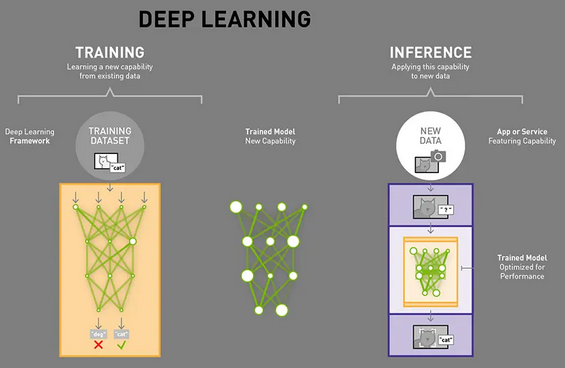

Sursa: https://blogs.nvidia.com/blog/2016/08/22/difference-deep-learning-training-inference-ai/

In [ ]:
# salvam toate datele
import pickle
pickle.dump( {'words':words, 'classes':classes, 'train_x':train_x, 'train_y':train_y}, open( "training_data", "wb" ) )

## 2. Chatbotul

Vom construi un automat de stari simplu pentru a raspunde automat intr-o conversatie cu o persoana reala. Folosind modelul de intentii antrenat anterior, chatbotul va clasifica fiecare text pe care il primeste intr-una din intentiile pe care a invatat sa le recunoasca.

Acest chatbot spunem ca este supervizat (a invatat din exemple adnotate anterior). Exista si modele nesupervizate care pot sa infere patternuri din diverse exemple de conversatii.

Reincarcam modelul de clasificare, documentele si intentiile.

Chatbotul este separat de antrenarea modelului pentru intentii. Cu alte cuvinte, reantrenam modelul de clasificare doar daca schimbam structura/sabloanele pentru intentii.

In [ ]:
import pickle

data = pickle.load( open( "training_data", "rb" ) )
print(type(data))

for key in data.keys():
    print(key)

<class 'dict'>
words
classes
train_x
train_y


Extragem datele din dictionarul incarcat in liste separate.

In [ ]:
words = data['words']
classes = data['classes']
train_x = data['train_x']
train_y = data['train_y']

Reincarcam fisierul cu intentii.

In [ ]:
import json
with open('intents.json') as json_data:
    intents = json.load(json_data)

Inainte de a reincarca modelul din memorie trebuie sa definim structura sa in mod identic cu definitia data la antrenare.

In acest notebook variabila `model` deja contine aceasta definitie deci putem incarca direct weighturile.

In [ ]:
# incarcam weight-urile salvate pentru cel mai bun model de clasificare
model.load('model.tflearn')

INFO:tensorflow:Restoring parameters from /content/model.tflearn


Inputul pentru model trebuie sa fie tot un vector, ca mai devreme.

Pentru aceasta, vom aplica aceeasi metoda de a transforma inputul utilizatorului folosind tehnica bag-of-words.

In [ ]:
def clean_up_sentence(sentence):
    # tokenizare
    sentence_words = nltk.word_tokenize(sentence)
    # stemming
    sentence_words = [stemmer.stem(word.lower()) for word in sentence_words]
    return sentence_words

# reprezentare binara bag-of-words
def bow(sentence, words):
    sentence_words = clean_up_sentence(sentence)
    # bag of words
    bag = [0]*len(words)  
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s: 
                bag[i] = 1

    return(np.array(bag))

In [ ]:
sentence = "how are you today?"
print(clean_up_sentence(sentence))
p = bow(sentence, words)

print(type(p), p)
result = np.where(p == 1)
print(result)
print(words[3])
print(words[23])
print(words[53])
print(words[60])

['how', 'ar', 'you', 'today', '?']
<class 'numpy.ndarray'> [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
(array([ 3, 23, 53, 60]),)
ar
how
today
you


Putem acum construi modalitatea de raspuns a chatbotului.

In primul rand, realizam clasificarea textului primit de la utilizator pentru intentia corespunzatoare. In aceasta functie, folosim `model.predict` pentru a prezice probabilitatea fiecarei clase.

Dorim sa gasim intentia cu probabilitate maxima. Pentru aceasta:
* filtram intentiile pentru care probabilitatea prezisa este sub `ERROR_THRESHOLD`;
* sortam intentiile descrescator conform probabilitatii returnate.

Apoi, construim o lista de perechi `(intentie, probabilitate)`.

In [ ]:
ERROR_THRESHOLD = 0.25
def classify(sentence):
    # probabilitatile prezise de model
    results = model.predict([bow(sentence, words)])[0]
    # renuntam la intentiile cu probabilitate mica
    results = [[i,r] for i,r in enumerate(results) if r>ERROR_THRESHOLD]
    # sortam descrescator intentiile dupa probabilitate
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append((classes[r[0]], r[1]))
    # return perechi (intentie, probabilitate)
    return return_list

classify("hello there")

[('greeting', 0.95699275)]

Definim acum functia care returneaza un raspuns catre utilizator.



In [ ]:
def response(sentence):
    results = classify(sentence)
    # print("results", results)
    # daca avem macar o intentie valida, o procesam pe cea cu probabilitate maxima
    if results:
        while results:
            for i in intents['intents']:
                # cautam in dictionarul de intentii tagul returnat
                if i['tag'] == results[0][0]:
                    # returnam un raspuns aleator corespunzator intentiei
                    return random.choice(i['responses'])

            results.pop(0)  # daca nu am putut da un raspuns pentru aceasta intentie, trecem la urmatoarea cu probabilitate maxima
    
    return "Sorry, I wasn't trained about this subject."  # nu a putut fi stabilita o intentie pentru fraza introdusa

print(response("hello there"))

Hello, how are you today?


Acum putem crea o conversatie intr-un loop infinit

In [ ]:
try:
    while True:
        print(response(input("user: ")))
except KeyboardInterrupt:
    pass

user: hi there
Hi there, how are you?
user: not very good
Oh, I know jokes to make you feel better.
user: alright, tell me a joke
When Chuck Norris cuts an onion, he doesn't cry, the onion cries!
user: hahahaha
Happy to make you smile
user: see ya
See you later


## 3. Contextualizare

Atunci cand raspund chatbotului cum ma simt, as vrea ca acesta sa retina intr-o stare aceasta informatie, ca restul conversatiei sa decurga in acest context.

De aceea, vom introduce o 'stare' in frameworkul nostru. Vom mentine o structura de date si codul corespunzator manipularii acesteia in functie de intentiile procesate.

Avem aici un exemplu de procesare a raspunsurilor folosind o metoda simpla de contextualizare:

In [ ]:
# structura de date pentru context
context = {}

# retinem pentru un user contextul curent, in functie de un ID specific
def response(sentence, userID='123', show_details=False):
    results = classify(sentence)
    # daca avem macar o intentie valida, o procesam pe cea cu probabilitate maxima
    if results:
        # loop as long as there are matches to process
        while results:
            for i in intents['intents']:
                # cautam in dictionarul de intentii tagul returnat
                if i['tag'] == results[0][0]:
                    # daca intentia curenta asteapta un context pentru a fi valida, verificam ca contextul actual sa fie indeplinit
                    if (
                        not 'context_filter' in i
                        or (userID in context and 'context_filter' in i and i['context_filter'] == context[userID])
                    ):
                        if show_details:
                            print('tag:', i['tag'])
                        # daca intentia curenta actualizeaza contextul
                        if 'context_set' in i:
                            if show_details:
                                print('context:', i['context_set'])
                            context[userID] = i['context_set']
                        # returnam un raspuns aleator corespunzator intentiei
                        return random.choice(i['responses'])
            results.pop(0) # daca nu am putut da un raspuns pentru aceasta intentie, trecem la urmatoarea cu probabilitate maxima

    return "Sorry, I wasn't trained about this subject."  # nu a putut fi stabilita o intentie pentru fraza introdusa

In [ ]:
try:
    while True:
        print(response(input("user: ")))
except KeyboardInterrupt:
    pass

user: hi
Hello, how are you today?
user: pretty good
Yay, thats's great news!
user: bye
See you later


Pentru a seta contextul intr-o intentie, putem specifica o eticheta in `context_set`:

```
{“tag”: “rental”,
“patterns”: [“Can we rent a moped?”, “I’d like to rent a moped”, … ],
“responses”: [“Are you looking to rent today or later this week?”],
“context_set”: “rentalday”
}
```

Pentru a stabili o succesiune contextuala cu o alta intentie, scriem aceeasi eticheta in campul `context_filter` al celei din urma.

```
{“tag”: “today”,
“patterns”: [“today”],
“responses”: [“For rentals today please call 1–800-MYMOPED”, …],
“context_filter”: “rentalday”
}
```

In acest exemplu, daca un utilizator ar fi scris 'today' fara niciun context precedent, intentia cu tagul 'today' nu va fi procesata. Daca ar introduce textul 'today' ca un raspuns la clarificarea ceruta de chatbot (intentia cu tagul 'rental'), atunci intentia 'today' ar fi fost procesata.



# TASK
## Deadline: 28 aprilie ora 23:59.

Formular pentru trimiterea temei: https://forms.gle/K3gQ7VXVHi7YJ5aX8

1. Creati un chatbot cu 20 de intentii, care poate sustine o conversatie pe orice tema doriti. Fiecare lista de sabloane a fiecarei intentii va avea cel putin 5 exemple. Cu cat mai multe exemple (patterns) pentru o intentie, cu atat va fi mai usor pentru chatbot sa o recunoasca.

2. Folositi mecanismul de stocare a contextului pentru a evita situatiile in care chatbotul recunoaste intentii care nu se potrivesc raspunsurilor anterioare.

3. Incarcati fisierul `intents.json` astfel construit impreuna cu notebook-ul folosit care sa contina OBLIGATORIU mai multe exemple de conversatii.